In [1]:
import numpy as np

%load_ext autoreload
%autoreload 2
from darksight.darksight import *

%matplotlib inline

In [32]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def logit(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def forward(self, x):
        return F.log_softmax(self.logit(x), dim=1)
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader) * args.batch_size,
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    n = 0
    with torch.no_grad():
        for data, target in test_loader:
            n += data.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= n
    acc = 100. * correct / n

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, n, acc))
    
    return acc
    
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=10, metavar='N',
                    help='input batch size for training (default: 10)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args([])
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False, **kwargs)
train_batch_list = list(train_loader)
# We need well balacned initial 20
train_batch_selected = []
for _ in range(2):
    for (i,(x,y)) in enumerate(train_batch_list):
        counter = dict()
        for yi in y:
            counter[yi.item()] = 1
        if len(counter.keys()) == 10:
            train_batch_selected.append(train_batch_list.pop(i))
            break
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# for epoch in range(1, args.epochs + 1):
#     train(args, model, device, train_loader, optimizer, epoch)
#     test(args, model, device, test_loader)

In [33]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

Train Epoch: 1 [0/20 (0%)]	Loss: 2.304946
Train Epoch: 2 [0/20 (0%)]	Loss: 2.272627
Train Epoch: 3 [0/20 (0%)]	Loss: 2.234449
Train Epoch: 4 [0/20 (0%)]	Loss: 2.195366
Train Epoch: 5 [0/20 (0%)]	Loss: 2.156021
Train Epoch: 6 [0/20 (0%)]	Loss: 2.115283
Train Epoch: 7 [0/20 (0%)]	Loss: 2.072171
Train Epoch: 8 [0/20 (0%)]	Loss: 2.024688
Train Epoch: 9 [0/20 (0%)]	Loss: 1.972375
Train Epoch: 10 [0/20 (0%)]	Loss: 1.914886

Test set: Average loss: 1.8533, Accuracy: 20/20 (100%)


Test set: Average loss: 2.1393, Accuracy: 4093/10000 (41%)

[Knowledge.__init__] <class 'torch.Tensor'> with size of torch.Size([10000, 10]) is loaded
-------+--------+---
 Epoch |  Loss  | T 
-------+--------+---
   100 | 0.0072 | 1
   200 | 0.0058 | 1
   300 | 0.0053 | 1
   400 | 0.0067 | 1
   500 | 0.0048 | 1
   600 | 0.0048 | 1
   700 | 0.0048 | 1
   800 | 0.0047 | 1
   900 | 0.0047 | 1
  1000 | 0.0046 | 1
Time used: 78.560879
Final loss: 0.004647
Accuracy to teacher: 100.0000
Train Epoch: 1 [0/30 (0%)]	Loss: 1.

KeyboardInterrupt: 

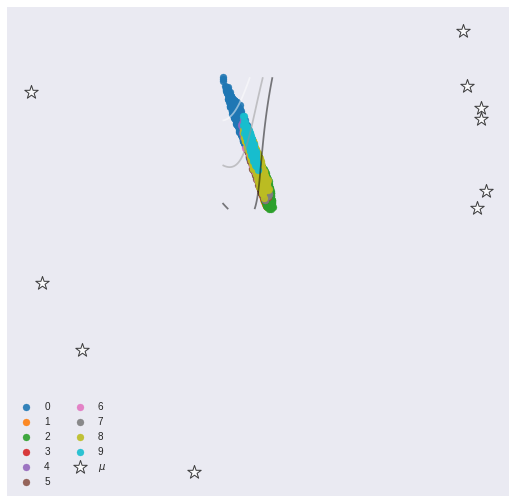

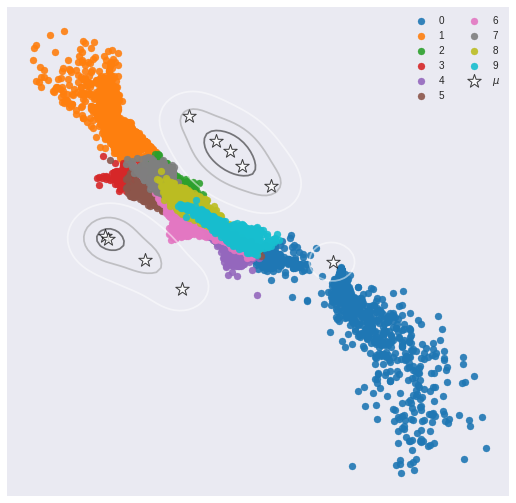

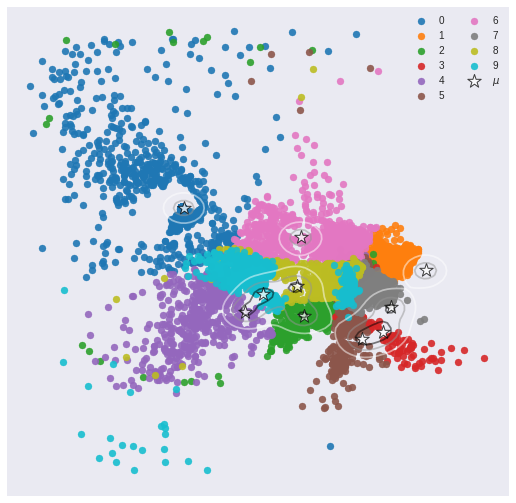

In [ ]:
is_ds_active = True
ds_epoch = 1000
candidate_num_batchs = 1000

tr_acc = []
te_acc = []
for _ in range(100):
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_batch_selected, optimizer, epoch)

    tr_acc.append(test(args, model, device, train_batch_selected))
    te_acc.append(test(args, model, device, test_loader))

    logit = []
    for data, target in train_batch_list[:candidate_num_batchs]:
        logit.append(model.logit(data.to(device)).detach().cpu().numpy())
    logit = np.concatenate(logit, 0)

    if is_ds_active:
        klg = Knowledge(logit, T=1)
        ds = DarkSight(klg)
        ds.ready(use_cuda=use_cuda)
        ds.train(ds_epoch, [2e-2, 1e-2, 1e-6])
        _, Z = ds.clf.posterior(ds._y, return_Z=True)
        ds.plot_y(contour_on=True, use_cuda=use_cuda)

        Z_np = Z.detach().cpu().numpy()[:,0]
        idcs = np.argpartition(Z_np, args.batch_size)[:args.batch_size]
        
        data = torch.cat(map(lambda x: x[0], train_batch_list[:candidate_num_batchs]), 0)
        target = torch.cat(map(lambda x: x[1], train_batch_list[:candidate_num_batchs]), 0)
        train_batch_list = train_batch_list[candidate_num_batchs:]
        
        data_list = []
        target_list = []
        data_selected_list = []
        target_selected_list = []        
        for i in range(len(Z_np)):
            if i in idcs:
                data_selected_list.append(data[i:i+1,:,:,:])
                target_selected_list.append(target[i].item())
            else:
                data_list.append(data[i:i+1,:,:,:])
                target_list.append(target[i].item())
        data = torch.cat(data_list, dim=0)
        target = torch.tensor(target_list)
        train_batch_list = list(zip([data[i*args.batch_size:(i+1)*args.batch_size,:,:] for i in range(candidate_num_batchs-1)], 
                                    [target[i*args.batch_size:(i+1)*args.batch_size] for i in range(candidate_num_batchs-1)])) + train_batch_list
        train_batch_selected.append([torch.cat(data_selected_list, dim=0), torch.tensor(target_selected_list)])
    else:
        i = np.random.randint(20)
        train_batch_selected.append(train_batch_list.pop(i))

## Logs below

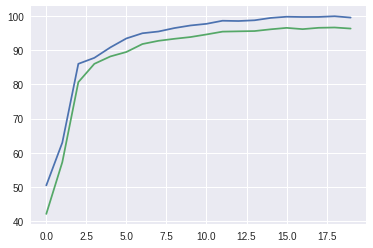

In [100]:
# without DS
# Test set: Average loss: 0.0211, Accuracy: 3980/4000 (100%)
# Test set: Average loss: 0.1398, Accuracy: 9630/10000 (96%)
plt.plot(tr_acc)
plt.plot(te_acc)

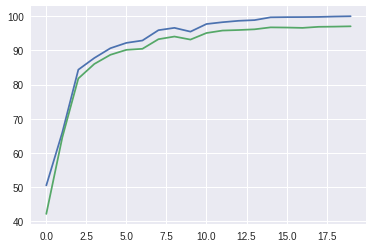

In [108]:
# with DS (select batch)
# Test set: Average loss: 0.0102, Accuracy: 3998/4000 (100%)
# Test set: Average loss: 0.1103, Accuracy: 9701/10000 (97%)
plt.plot(tr_acc)
plt.plot(te_acc)

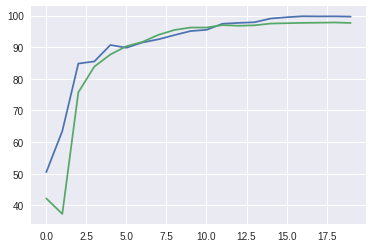

In [180]:
# with DS (selected individuals)
# Test set: Average loss: 0.0160, Accuracy: 3987/4000 (100%)
# Test set: Average loss: 0.0908, Accuracy: 9767/10000 (98%)
plt.plot(tr_acc)
plt.plot(te_acc)